## Denosing Diffusion Optimal Models

In [ ]:
using Plots
using Flux
using BSON
using JSON
using StatsBase
using Printf

In [ ]:
using Revise
includet("../common/datasets.jl");
includet("../common/utilities.jl");
includet("../common/argmin_func.jl");

## Data

In [ ]:
num_samples = 1000;
points = randn(2, num_samples);

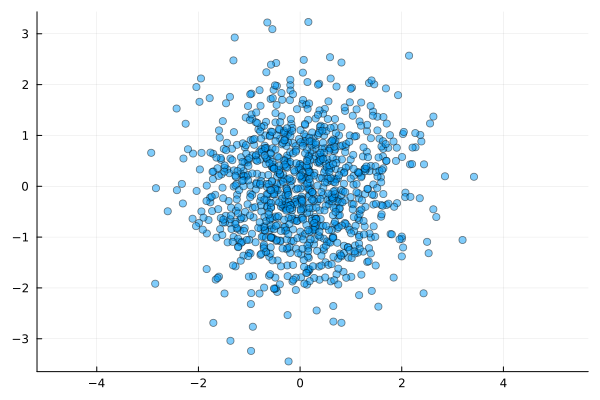

In [ ]:
scatter(points[1, :], points[2,:], alpha=0.5, label="", aspectratio=:equal)

## Optimal solution

In [ ]:
## spiral
θmin = 1.5π
θmax = 4.5π
xmax = 4.5π
xmin = -3.5π
x_func(t) = t * cos(t) 
y_func(t) = t * sin(t)

## normalize
scale = 2/(xmax - xmin)
shift = -1 - scale * xmin

x_func_norm(t) = scale * x_func(t) + shift
y_func_norm(t) = scale * y_func(t) + shift

θ = (θmin:0.01:θmax)
x = x_func_norm.(θ);
y = y_func_norm.(θ);

In [ ]:
f(p, t)   = (x_func_norm(t) - p[1])^2 + (y_func_norm(t) - p[2])^2;
## spiral
df(p, t)  = t * scale + (shift - p[1]) * (cos(t) - t * sin(t)) + (shift - p[2]) * (sin(t) + t * cos(t));
ddf(p, t) = 1 * scale - (shift - p[1]) * (2sin(t) + t * cos(t)) + (shift - p[2]) * (2cos(t) - t * sin(t));
## solver
solver(p) = argmin_func_newton(t->f(p, t), t->df(p, t), t->ddf(p, t), θmin, θmax, length=100)
#solver(p) = argmin_func_bisection(t->f(p, t), t->df(p, t), θmin, θmax, length=1000)

solver (generic function with 1 method)

In [ ]:
θs = [solver(points[:, i]) for i in 1:num_samples]
x0s = x_func_norm.(θs)
y0s = y_func_norm.(θs)
X0s = permutedims(hcat(x0s, y0s));

┌ Warning: gradient=-0.04433880057240125 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.27806651021540946 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.012039298499338658 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.145495778384568 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37


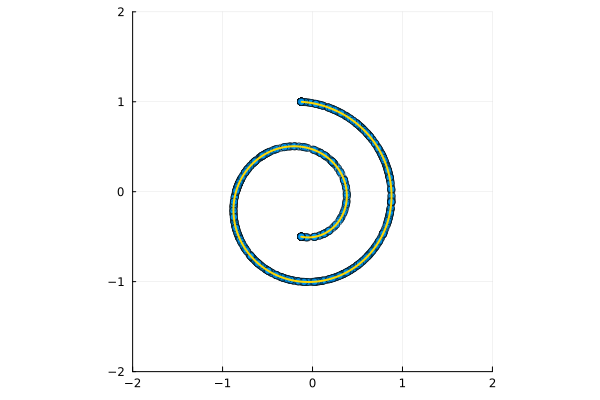

In [ ]:
p = scatter(X0s[1, :], X0s[2, :], alpha=0.5, label="", aspectratio=:equal, xlims=(-2, 2), ylims=(-2, 2))
#scatter!(p, points[1, :], points[2,:], alpha=0.5)
plot!(p, x, y, label="", linewidth=2, color=:gold)

Starting similarity: 0.5154


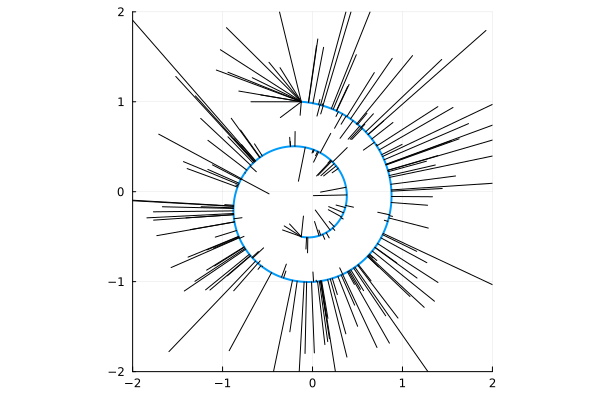

In [ ]:
n = 200
p = plot(x, y, linewidth=2, aspectratio=:equal, label="", xlims=(-2, 2), ylims=(-2, 2))
for i in 1:n
    plot!(p, [points[1, i] ; X0s[1, i]], [points[2, i]; X0s[2, i]], label="", color=:black )
end
closest_distances = [sqrt(f(points[:, i], θs[i])) for i in 1:num_samples]
similarities = mean(closest_distances)
@printf("Starting similarity: %.4f\n", similarities)
p

## Animations

In [ ]:
num_timesteps = 40;

In [ ]:
# sub-optimal: update at every iteration
XT = points
X_opt = Array{Float32}(undef, size(XT)..., 0)
X = XT
@time for timestep in 1:num_timesteps
    θs = [solver(X[:, i]) for i in 1:num_samples]
    x0 = x_func_norm.(θs)
    y0 = y_func_norm.(θs)
    X0 = permutedims(hcat(x0, y0))
    X += 1/(num_timesteps - timestep + 1) * (X0 - X)
    X_opt = cat(X_opt, X, dims=3)
end

┌ Warning: gradient=-0.04433880057240125 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.27806651021540946 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.012039298499338658 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.145495778384568 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37
┌ Warning: gradient=0.002937752921663983 is too low for Newton's method. Returning seed without optimization.
└ @ Main C

┌ Warning: gradient=0.2553633291552253 is too low for Newton's method. Returning seed without optimization.
└ @ Main C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\common\argmin_func.jl:37


  5.072714 seconds (80.05 M allocations: 1.439 GiB, 7.89% gc time, 25.54% compilation time)


In [ ]:
# optimal: predetermined at start
XT = points
X_opt = Array{Float32}(undef, size(XT)..., 0)
for timestep in 1:num_timesteps
    z = XT + timestep/num_timesteps * (X0s - XT)
    X_opt = cat(X_opt, z, dims=3)
end

In [ ]:
X_opt[:, 365:370, 1]

2×6 Matrix{Float64}:
 -0.250473  1.99296  -0.578039  -0.195032   0.38607   -1.23098
 -0.273349  1.01181  -1.31596    0.477278  -0.993089  -0.829454

In [ ]:
anim_optimal = @animate for i ∈ 1:(num_timesteps + 10)
    i = i > num_timesteps ? num_timesteps : i
    scatter(X_opt[1, :, i], X_opt[2,:, i], 
        alpha=0.5, 
        title="i=$i", 
        label="",
        aspectratio=:equal,
        xlims=(-2, 2), ylims=(-2, 2),
        figsize=(400, 400),
    )
end

Animation("C:\\Users\\sinai\\AppData\\Local\\Temp\\jl_UscDoP", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000041.png", "000042.png", "000043.png", "000044.png", "000045.png", "000046.png", "000047.png", "000048.png", "000049.png", "000050.png"])

[ Info: Saved animation to C:\Users\sinai\Documents\Projects\Julia projects\DenoisingDiffusion-examples\outputs\spiral_optimal.gif


Plots.AnimatedGif("C:\\Users\\sinai\\Documents\\Projects\\Julia projects\\DenoisingDiffusion-examples\\outputs\\spiral_optimal.gif")
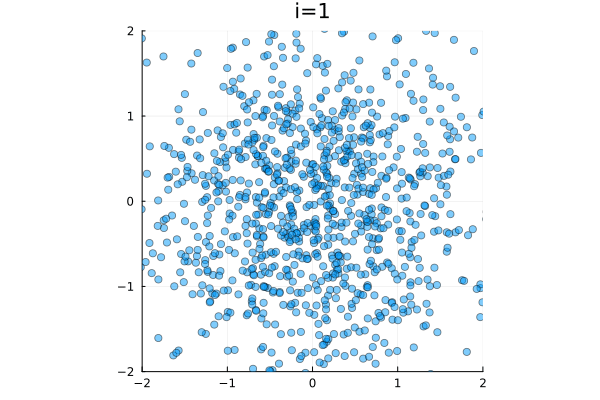

In [ ]:
gif(anim_optimal, joinpath("../outputs", "spiral_optimal.gif"), fps=8)